In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../data/" directory

import os
import os.path as osp

ds_name = '04272021'
ds_folder = f'../data/{ds_name}'
for dirname, _, filenames in os.walk(ds_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/04272021/edges.csv
../data/04272021/cluster_dynamics.csv
../data/04272021/split_rs123/test.csv
../data/04272021/split_rs123/train.csv
../data/04272021/split_rs123/test_edge.csv
../data/04272021/split_rs123/train_edge.csv


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [4]:
#Import the files
node_df = pd.read_csv(f'{ds_folder}/cluster_dynamics.csv')
edge_df = pd.read_csv(f'{ds_folder}/edges.csv')

In [5]:
print('Shape of node data is', node_df.shape)
print ('Shape of edge data is', edge_df.shape)

Shape of node data is (3990589, 20)
Shape of edge data is (3948750, 5)


In [6]:
#check the train data
node_df.tail()

# so there are around 20 features here in this dataset (But 02172021 only has 19 features)

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node
3990584,9,C,static,NaN,c4,0.604319,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3990585,9,D,static,NaN,c2,0.886956,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3990586,9,E,static,NaN,c5,0.802538,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3990587,9,F,growth,0.0403140430180747,c6,0.883474,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3990588,9,G,decay,0.219002927451965,c3,0.653183,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Q1: Does `Node==None` mean the node is not on the tree? (It is not background node, with numerical cluster id)
A1:

### Q2: Node with `Node==None` has `dynamic in [Nan, real number]` and `dynamic_model in c{Int}`？
A2:

### Q3: How to process nodes with `Node==None`? 
A3:

In [7]:
#impute missing data of dynamic model to 0 (TBD)
impute_node = np.where(pd.isna(node_df['dynamic_model'])==True)
node_df.loc[(impute_node[0]),'dynamic_model']=0

#drop non-node data points
drop_node = np.where(pd.isna(node_df['node'])==True)
node_df = node_df.drop(drop_node[0])
print('Number of dropped node is', len(drop_node[0]))

Number of dropped node is 39032


In [8]:
print('Shape of node data is', node_df.shape)

Shape of node data is (3951557, 20)


In [9]:
node_df.tail()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node
3990577,c6,99,C,static,0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,541.0
3990578,c6,99,C,static,0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,941.0
3990579,c6,99,C,static,0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,939.0
3990580,c6,99,C,static,0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,329.0
3990581,c6,99,C,static,0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,542.0


In [10]:
node_df["dynamic_model"].unique()

array([0, '0.559118093533358', '0.0134283743394147', ...,
       '0.441388359739659', '0.506102147526221', '0.0179045482088513'],
      dtype=object)

### Q4: `dynamic_model in [0, R] `, but in data `02172021` only three string types [`exp`, 'linear', 'stable']
A4:

In [9]:
#information about the node data set
node_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3951557 entries, 7 to 3990581
Data columns (total 20 columns):
 #   Column                Dtype  
---  ------                -----  
 0   cluster_id            object 
 1   sim                   object 
 2   state                 object 
 3   dynamic               object 
 4   dynamic_model         object 
 5   v_sampling_fraction   float64
 6   v_cluster_size        int64  
 7   v_timespan            float64
 8   gamma                 float64
 9   oster                 float64
 10  birth_rate            float64
 11  PD                    float64
 12  R0                    float64
 13  abs_growth_rate       float64
 14  fraction_time_growth  float64
 15  r_max                 float64
 16  ltt_shape             object 
 17  cherries              float64
 18  BLD                   float64
 19  node                  float64
dtypes: float64(13), int64(1), object(6)
memory usage: 633.1+ MB


### Q5: New features: BLD, do we need to use it and how to process?
A5:

In [10]:
node_df.describe()

,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,cherries,BLD,node
count,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06,3.951557e+06
mean,1.437753e-01,5.557365e+02,8.332570e+01,inf,8.333262e+01,4.935660e+02,1.359841e+04,-2.886865e+03,6.346556e+09,4.825717e-01,2.818265e+03,3.270833e-01,4.074069e+00,7.134104e+02
std,2.268431e-01,2.103211e+02,2.621830e+01,NaN,2.620902e+01,9.887452e+04,5.538338e+03,2.851270e+05,1.294364e+12,3.067652e-01,9.490723e+04,2.338149e-02,3.874192e+00,4.228524e+02
min,4.088723e-02,5.000000e+00,3.000000e+00,-6.179215e+03,3.090909e+00,2.314829e-02,5.000000e+00,-1.448334e+08,1.334146e-03,0.000000e+00,-5.639996e+07,1.000000e-01,-7.200000e+01,1.000000e+00
25%,5.531411e-02,5.530000e+02,8.300000e+01,-1.719504e+01,8.300416e+01,3.418333e-02,1.387000e+04,-7.487323e-01,8.764582e+01,2.173913e-01,2.719098e+03,3.222061e-01,4.000000e+00,3.520000e+02
50%,6.051423e-02,6.080000e+02,9.000000e+01,-1.623615e+01,9.000370e+01,3.570311e-02,1.537000e+04,9.054323e-01,1.174670e+02,4.791667e-01,3.762441e+03,3.288889e-01,5.000000e+00,7.040000e+02
75%,6.859314e-02,6.640000e+02,9.700000e+01,-1.444427e+01,9.700333e+01,3.868524e-02,1.656500e+04,2.204702e+00,1.477896e+02,7.454545e-01,4.773502e+03,3.346995e-01,6.000000e+00,1.056000e+03
max,9.999999e-01,1.188000e+03,1.540000e+02,inf,1.540019e+02,3.503330e+07,2.462700e+04,8.031474e+00,2.881675e+14,1.000000e+00,4.215281e+04,5.000000e-01,1.500000e+01,2.546000e+03


In [11]:
# import pandas_profiling
# node_df.profile_report() 

In [12]:
#check for the missing values in the node data
node_df.isnull().sum()

cluster_id              0
sim                     0
state                   0
dynamic                 0
dynamic_model           0
v_sampling_fraction     0
v_cluster_size          0
v_timespan              0
gamma                   0
oster                   0
birth_rate              0
PD                      0
R0                      0
abs_growth_rate         0
fraction_time_growth    0
r_max                   0
ltt_shape               0
cherries                0
BLD                     0
node                    0
dtype: int64

In [13]:
# Check which variables have missing values

node_columns_with_missing_values = node_df.columns[node_df.isnull().any()]
node_df[node_columns_with_missing_values].isnull().sum()

Series([], dtype: float64)

In [14]:
# total missing values in the entire df
node_df.isnull().sum().sum()

0

In [15]:
missing_series = node_df.isnull().sum() 
missing_series.where(missing_series>1000)
missing_series.loc[missing_series>1000]/node_df.shape[0] # to locate the missing values that are more than 1000

Series([], dtype: float64)

### Preprocessing-1
1. Convert data type of sim and dynamic model from str to numeric
2. Impute missing data in dynamic model

In [16]:
node_df['sim'] = pd.to_numeric(node_df['sim'])
node_df['dynamic_model'] = pd.to_numeric(node_df['dynamic_model'])

In [17]:
# impute the missing values in dynamic_model 

In [18]:
node_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node
7,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,7.0
8,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,132.0
9,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,513.0
10,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,230.0
11,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,255.0


### Q6: Background nodes have feature values and labels, which are different from 02172021?
A6:

In [19]:
node_df.tail()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node
3990577,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,541.0
3990578,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,941.0
3990579,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,939.0
3990580,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,329.0
3990581,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,542.0


In [20]:
# Check which variables have missing values

node_columns_with_missing_values = node_df.columns[node_df.isnull().any()]
node_df[node_columns_with_missing_values].isnull().sum()

Series([], dtype: float64)

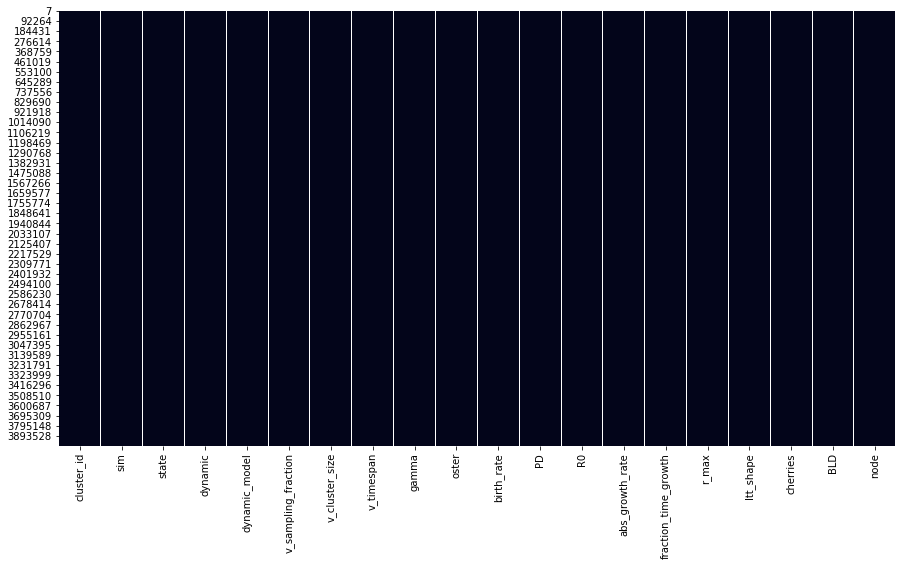

In [21]:
# Now using heatmaps
plt.figure(figsize=(15,8))
sns.heatmap(node_df.isnull(), cbar=False)
# FRom this heatmap too it is evident that the above 2 mentioned vars have more missing values

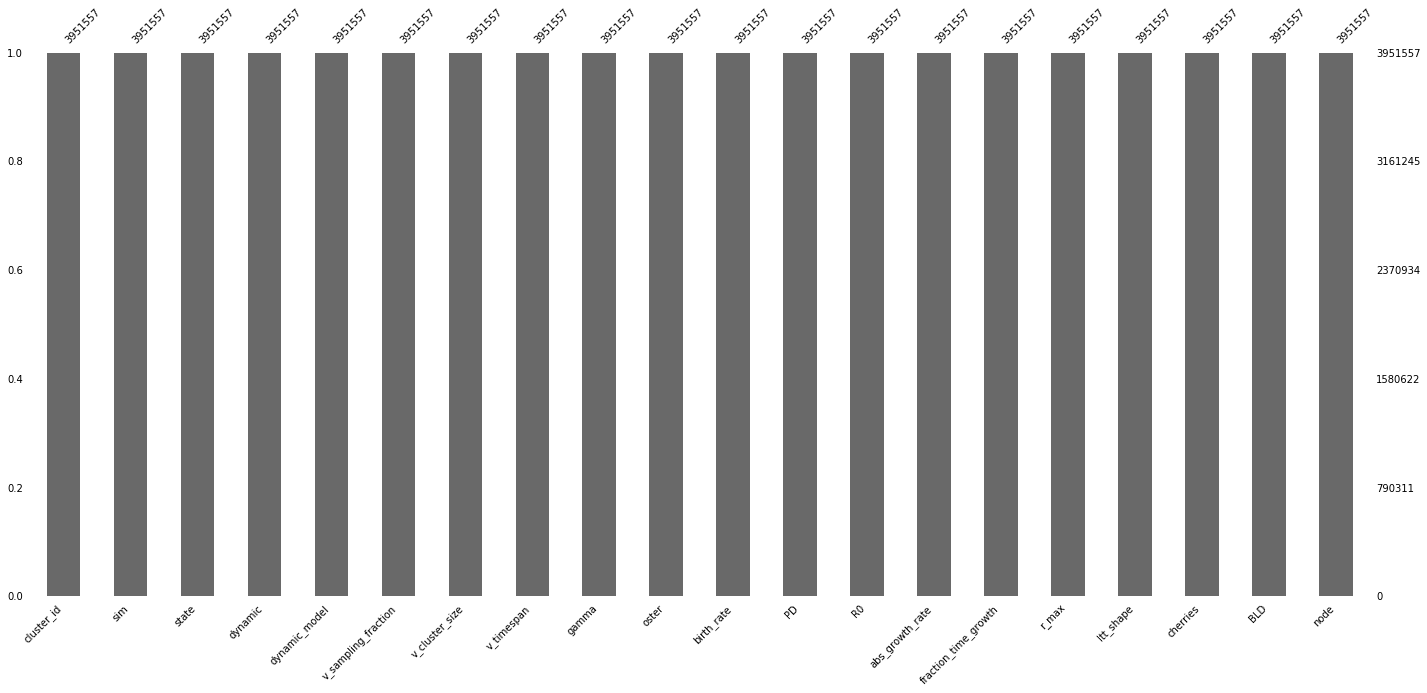

In [22]:
# Next is to use the missingno library to analyze the missing values
import missingno as msno 

msno.bar(node_df,labels=True,fontsize=10) 

D:\anaconda\lib\site-packages\seaborn\matrix.py:280: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
D:\anaconda\lib\site-packages\seaborn\matrix.py:280: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


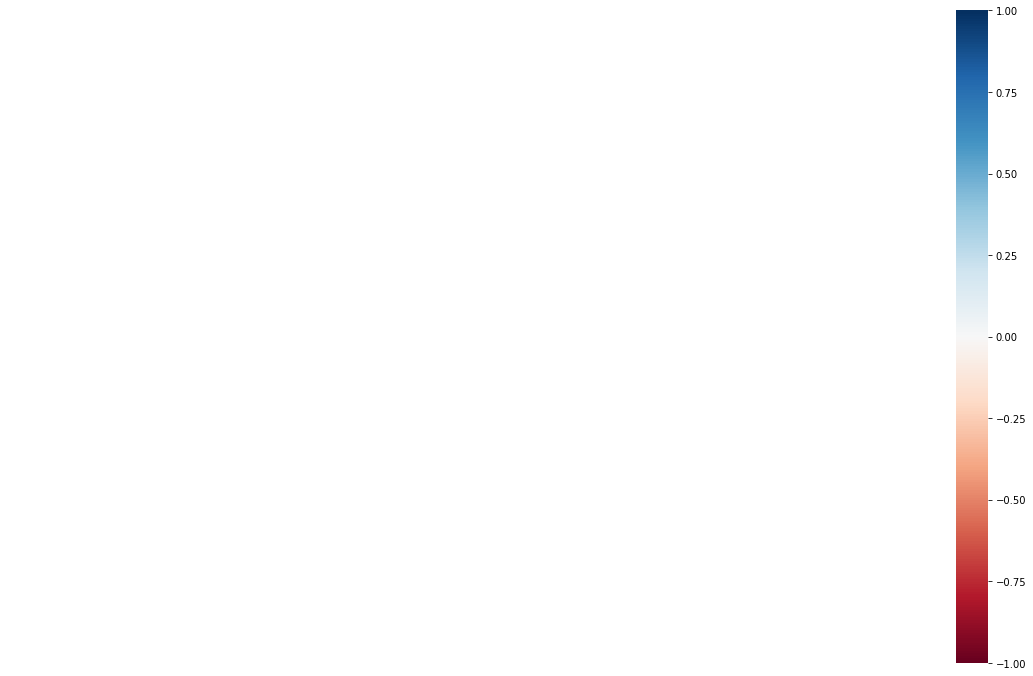

In [23]:
# The missingno correlation heatmap measures nullity correlation: 
# how strongly the presence or absence of one variable affects the presence of another:
msno.heatmap(node_df,labels=True) 

# Entries marked <1 or >-1 have a correlation that is close to being exactingly negative or positive, but is still not quite perfectly so
# Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears the other definitely also does)

### Count number of trees

In [24]:
tree_ids = node_df['sim'].unique()
num_trees = len(tree_ids)
print(f'Number of trees: {num_trees}')

Number of trees: 2315


Previous dataset includes 414 trees

### Preprocessing-2: Discretization
#### 2-1. R0 discretization
   * 3 ranges: $(-inf, 0]$, $(0, 1]$, $(1, +inf)$

count    3.951557e+06
mean    -2.886865e+03
std      2.851270e+05
min     -1.448334e+08
25%     -7.487323e-01
50%      9.054323e-01
75%      2.204702e+00
max      8.031474e+00
Name: R0, dtype: float64


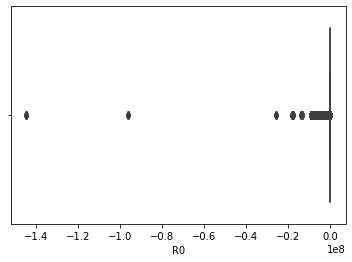

In [25]:
print(node_df['R0'].describe())
# f, ax = plt.subplots(figsize=(10, 6))
# ax.set_xscale("log")
sns.boxplot(x=node_df[node_df['R0'].notna()]['R0'])
# ax.xaxis.grid(True)

In [26]:
bins = pd.IntervalIndex.from_tuples([(float('-inf'), 0), (0, 1), (1, float('inf'))], closed='right')
print(bins)
r0_cats = pd.cut(node_df['R0'], bins)
r0_cat_dict = {cat: i for i, cat in enumerate(bins)}
print(r0_cat_dict)

IntervalIndex([(-inf, 0.0], (0.0, 1.0], (1.0, inf]],
              closed='right',
              dtype='interval[float64]')
{Interval(-inf, 0.0, closed='right'): 0, Interval(0.0, 1.0, closed='right'): 1, Interval(1.0, inf, closed='right'): 2}


In [27]:
node_df['R0_bin'] = r0_cats
node_df['R0_cat'] = node_df['R0_bin'].replace(r0_cat_dict, inplace=False)
node_df['R0_cat'].unique()

array([0, 2, 1], dtype=int64)

In [28]:
node_df.tail()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,R0_bin,R0_cat
3990577,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,541.0,"(-inf, 0.0]",0
3990578,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,941.0,"(-inf, 0.0]",0
3990579,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,939.0,"(-inf, 0.0]",0
3990580,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,329.0,"(-inf, 0.0]",0
3990581,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,542.0,"(-inf, 0.0]",0


#### Deprecate processing for R0 with Quantile-based discretization function. (Skip the below cell)

#### 2-2. Gamma discretization
    * Quantile-based discretization function

In [29]:
gamma_cats, gamma_bins = pd.qcut(node_df['gamma'], 4, retbins=True, duplicates='drop')
gamma_cat_dict = {cat: i for i, cat in enumerate(gamma_cats.unique())}
print(gamma_bins)
print(gamma_cat_dict)

[-6179.21497392   -17.19503903   -16.23615182   -14.44427167
            inf]
{Interval(-16.236, -14.444, closed='right'): 0, Interval(-14.444, inf, closed='right'): 1, Interval(-6179.216, -17.195, closed='right'): 2, Interval(-17.195, -16.236, closed='right'): 3}


In [30]:
node_df['gamma_bin'] = gamma_cats
node_df['gamma_cat'] = node_df['gamma_bin'].replace(gamma_cat_dict, inplace=False)
print(f'Gamma cat: {node_df["gamma_cat"].unique()}')
node_df.head()

Gamma cat: [0 1 2 3]


,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,R0_bin,R0_cat,gamma_bin,gamma_cat
7,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,7.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0
8,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,132.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0
9,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,513.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0
10,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,230.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0
11,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,255.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0


### Preprocessing-3 Encode the categorical feature and label
#### 3.1 Categorical features
    * ltt_shape
    * R0 (processed before)
    * gamma (processed before)

In [31]:
# Use to record all the feature transformations
feat_dict = dict()

In [32]:
node_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,R0_bin,R0_cat,gamma_bin,gamma_cat
7,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,7.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0
8,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,132.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0
9,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,513.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0
10,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,230.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0
11,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,255.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0


In [33]:
#First of all we need to get the columns where the categorical features are present
# idea is to extract all the columns with type as object
node_df.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64'),
       CategoricalDtype(categories=[(-inf, 0.0], (0.0, 1.0], (1.0, inf]],
       , ordered=True)                                                   ,
       CategoricalDtype(categories=[(-6179.216, -17.195], (-17.195, -16.236], (-16.236, -14.444], (-14.444, inf]],
       , ordered=True)                                                                                            ],
      dtype=object)

In [34]:
for types in node_df.dtypes.unique():
    print(types,len(node_df.select_dtypes(types).columns))
    print(node_df.select_dtypes(types).columns)
    print('===')

object 4
Index(['cluster_id', 'state', 'dynamic', 'ltt_shape'], dtype='object')
===
int64 4
Index(['sim', 'v_cluster_size', 'R0_cat', 'gamma_cat'], dtype='object')
===
float64 14
Index(['dynamic_model', 'v_sampling_fraction', 'v_timespan', 'gamma', 'oster',
       'birth_rate', 'PD', 'R0', 'abs_growth_rate', 'fraction_time_growth',
       'r_max', 'cherries', 'BLD', 'node'],
      dtype='object')
===
category 2
Index(['R0_bin', 'gamma_bin'], dtype='object')
===
category 2
Index(['R0_bin', 'gamma_bin'], dtype='object')
===


In [35]:
# Category the ltt_shape

# node_df = node_df.astype({'ltt_shape': 'category'}, copy=False)
node_df["ltt_shape"] = node_df["ltt_shape"].astype('category')
node_df["ltt_shape_cat"] = node_df["ltt_shape"].cat.codes
feat_dict['ltt_shape'] = dict(enumerate(node_df['ltt_shape'].cat.categories))
      
print(feat_dict)
node_df.head()

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}}


,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,R0_bin,R0_cat,gamma_bin,gamma_cat,ltt_shape_cat
7,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,7.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0,3
8,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,132.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0,3
9,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,513.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0,3
10,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,230.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0,3
11,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,255.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0,3


In [36]:
# Record the cat_dict for R0 and gamma, reverse the previous the dict
for feat_name, cat_dict in zip(['r0', 'gamma'], [r0_cat_dict, gamma_cat_dict]):
    tmp_dict = {}
    for k, v in cat_dict.items():
        tmp_dict[v] = f'{k.left, k.right, k.closed}'
    feat_dict[feat_name] = tmp_dict
print(feat_dict)

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}, 'r0': {0: "(-inf, 0.0, 'right')", 1: "(0.0, 1.0, 'right')", 2: "(1.0, inf, 'right')"}, 'gamma': {0: "(-16.236, -14.444, 'right')", 1: "(-14.444, inf, 'right')", 2: "(-6179.216, -17.195, 'right')", 3: "(-17.195, -16.236, 'right')"}}


#### 3.2 Categorical label
* Convert the dynamic column to the int value

In [37]:
node_df["dynamic"] = node_df["dynamic"].astype('category')
node_df["dynamic_cat"] = node_df["dynamic"].cat.codes
feat_dict['dynamic'] = dict(enumerate(node_df['dynamic'].cat.categories))
print(feat_dict)
node_df.tail()

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}, 'r0': {0: "(-inf, 0.0, 'right')", 1: "(0.0, 1.0, 'right')", 2: "(1.0, inf, 'right')"}, 'gamma': {0: "(-16.236, -14.444, 'right')", 1: "(-14.444, inf, 'right')", 2: "(-6179.216, -17.195, 'right')", 3: "(-17.195, -16.236, 'right')"}, 'dynamic': {0: 'decay', 1: 'growth', 2: 'static'}}


,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,R0_bin,R0_cat,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat
3990577,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,541.0,"(-inf, 0.0]",0,"(-14.444, inf]",1,2,2
3990578,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,941.0,"(-inf, 0.0]",0,"(-14.444, inf]",1,2,2
3990579,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,939.0,"(-inf, 0.0]",0,"(-14.444, inf]",1,2,2
3990580,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,329.0,"(-inf, 0.0]",0,"(-14.444, inf]",1,2,2
3990581,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,542.0,"(-inf, 0.0]",0,"(-14.444, inf]",1,2,2


### Split the nodes into background and non-background

In [38]:
background_df = node_df[node_df['cluster_id']=='Background']
background_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,R0_bin,R0_cat,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat
7,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,7.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0,3,2
8,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,132.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0,3,2
9,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,513.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0,3,2
10,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,230.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0,3,2
11,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,255.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0,3,2


In [39]:
node_df = node_df[node_df['cluster_id']!='Background']
node_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,R0_bin,R0_cat,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat
1004,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,1017.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2
1005,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,1018.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2
1006,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,1016.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2
1007,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,31.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2
1008,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,401.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2


### Analysis-1 Correlation 
#### 1-1. The relationship between categorical features and label

In [40]:
from sklearn.feature_selection import chi2, mutual_info_classif

cat_feat_cols = ['ltt_shape_cat', 'R0_cat', 'gamma_cat']
chi2_sts, p_vals = chi2(node_df[cat_feat_cols], node_df['dynamic_cat'])
mis = mutual_info_classif(node_df[cat_feat_cols], node_df['dynamic_cat'])

for cat, chi2, p_val, mi in zip(cat_feat_cols, chi2_sts, p_vals, mis):
    degree_freedom = (len(node_df['dynamic_cat'].unique()) - 1) * (len(node_df[cat].unique())-1)
    print(f'{cat}: \n  df: {degree_freedom}, chi2: {chi2}, p_vals: {p_val}\n  MI: {mi}')

ltt_shape_cat: 
  df: 6, chi2: 3797.4574196317003, p_vals: 0.0
  MI: 0.03604287891178459
R0_cat: 
  df: 4, chi2: 2693.7939525550823, p_vals: 0.0
  MI: 0.033714678961912936
gamma_cat: 
  df: 6, chi2: 7.6703772405325745, p_vals: 0.021597264404199217
  MI: 0.09077345461732111


### Analysis-1
#### 1-2 The relationship between numerical features and label(added BLD and dynamic model)

In [41]:
num_feat_cols = ["v_sampling_fraction", "v_cluster_size", "v_timespan", "oster", "birth_rate", "PD",
                 "abs_growth_rate", "fraction_time_growth", "r_max","cherries","BLD","dynamic_model"]

label_col = ["dynamic_cat"]
aly_col = num_feat_cols + cat_feat_cols + label_col
print(aly_col)

aly_df = node_df[aly_col]
print(aly_df.shape, f"num_feat: {len(num_feat_cols)}, cat_feat: {len(cat_feat_cols)}, label: {len(label_col)}")

['v_sampling_fraction', 'v_cluster_size', 'v_timespan', 'oster', 'birth_rate', 'PD', 'abs_growth_rate', 'fraction_time_growth', 'r_max', 'cherries', 'BLD', 'dynamic_model', 'ltt_shape_cat', 'R0_cat', 'gamma_cat', 'dynamic_cat']
(542178, 16) num_feat: 12, cat_feat: 3, label: 1


#### 1-2-1 Pearson R

In [42]:
# Compute pairwise correlation of columns (pearson R: standard correlation coefficient)
aly_df.corr()

,v_sampling_fraction,v_cluster_size,v_timespan,oster,birth_rate,PD,abs_growth_rate,fraction_time_growth,r_max,cherries,BLD,dynamic_model,ltt_shape_cat,R0_cat,gamma_cat,dynamic_cat
v_sampling_fraction,1.000000,-0.588848,-0.262452,-0.262641,0.000987,-0.380986,0.012728,0.050538,-0.006018,-0.061578,-0.099145,0.003844,0.058632,0.030902,0.011335,-0.010566
v_cluster_size,-0.588848,1.000000,0.553201,0.553394,-0.008383,0.754473,-0.007150,0.005371,0.013055,0.040043,0.196866,-0.111258,-0.164829,0.028874,0.011797,0.152209
v_timespan,-0.262452,0.553201,1.000000,0.999999,-0.018329,0.874225,-0.007968,0.121730,0.031345,0.018758,0.406567,-0.215637,-0.230909,0.120343,0.078364,0.327763
oster,-0.262641,0.553394,0.999999,1.000000,-0.018312,0.874330,-0.007950,0.121529,0.031161,0.018651,0.406146,-0.215622,-0.230764,0.120187,0.078360,0.327768
birth_rate,0.000987,-0.008383,-0.018329,-0.018312,1.000000,-0.013393,-0.000178,0.009496,0.000306,0.002775,-0.037292,-0.002524,0.005313,0.009289,-0.001805,0.001267
PD,-0.380986,0.754473,0.874225,0.874330,-0.013393,1.000000,-0.010884,0.109995,0.022016,0.042694,0.373600,-0.187200,-0.288043,0.121751,0.056360,0.285514
abs_growth_rate,0.012728,-0.007150,-0.007968,-0.007950,-0.000178,-0.010884,1.000000,-0.016129,0.000280,-0.026220,0.002606,-0.004035,0.004709,-0.013012,-0.001499,0.005775
fraction_time_growth,0.050538,0.005371,0.121730,0.121529,0.009496,0.109995,-0.016129,1.000000,0.027950,0.002509,0.038481,-0.041419,-0.077480,0.296581,0.006046,0.054162
r_max,-0.006018,0.013055,0.031345,0.031161,0.000306,0.022016,0.000280,0.027950,1.000000,-0.009798,0.025883,-0.006628,-0.008180,0.022500,0.002607,0.010553
cherries,-0.061578,0.040043,0.018758,0.018651,0.002775,0.042694,-0.026220,0.002509,-0.009798,1.000000,0.032772,0.010344,-0.016412,-0.006340,-0.012921,0.000226


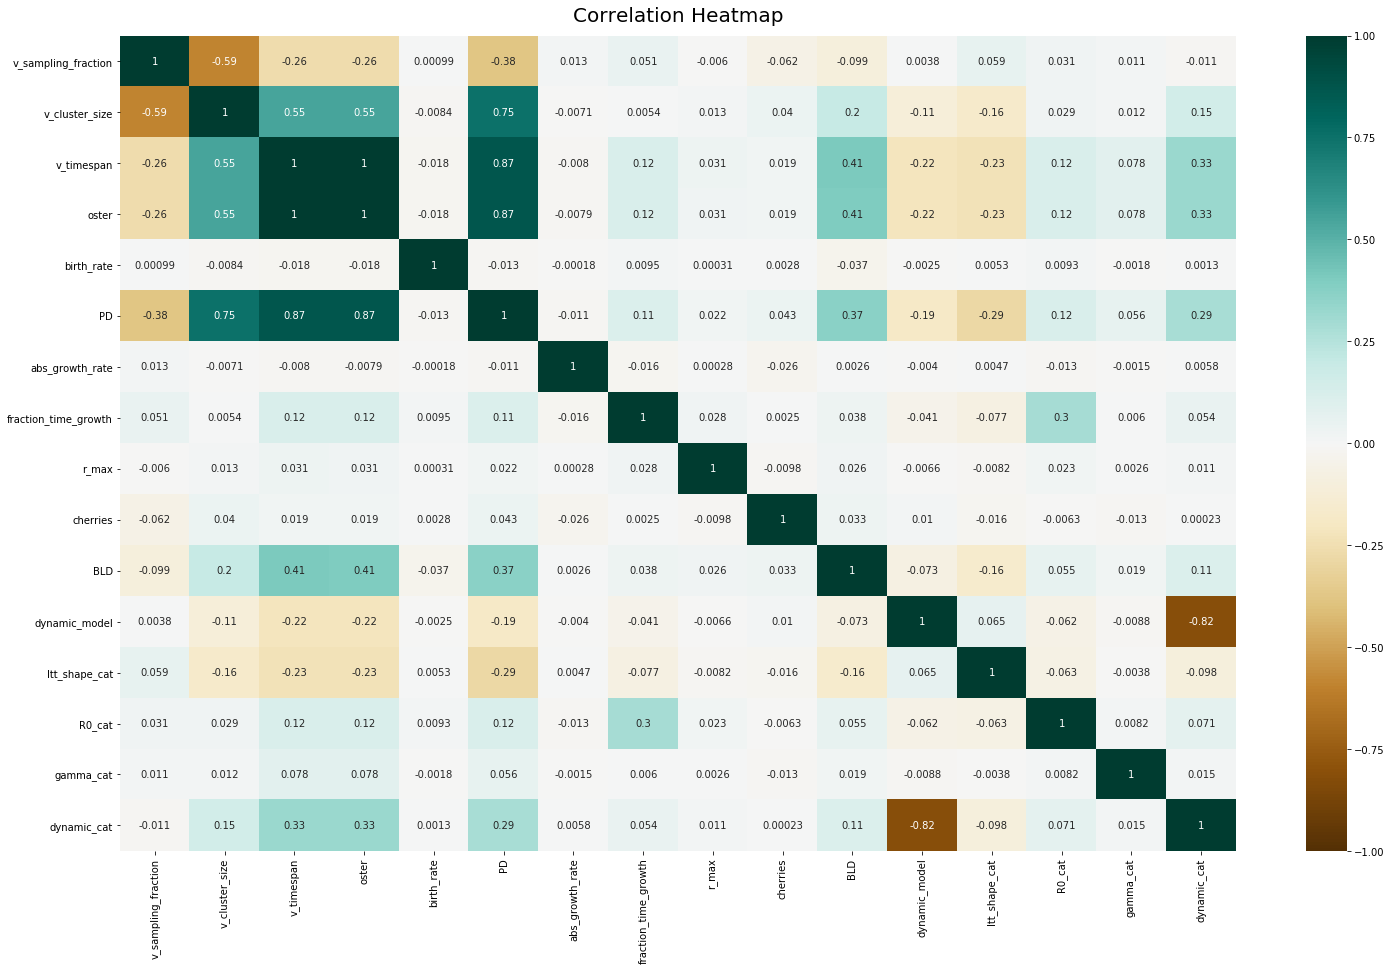

In [43]:
# Pearson Correlation Matrix

# Increase the size of the heatmap.
plt.figure(figsize=(25, 15))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(aly_df.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=14);

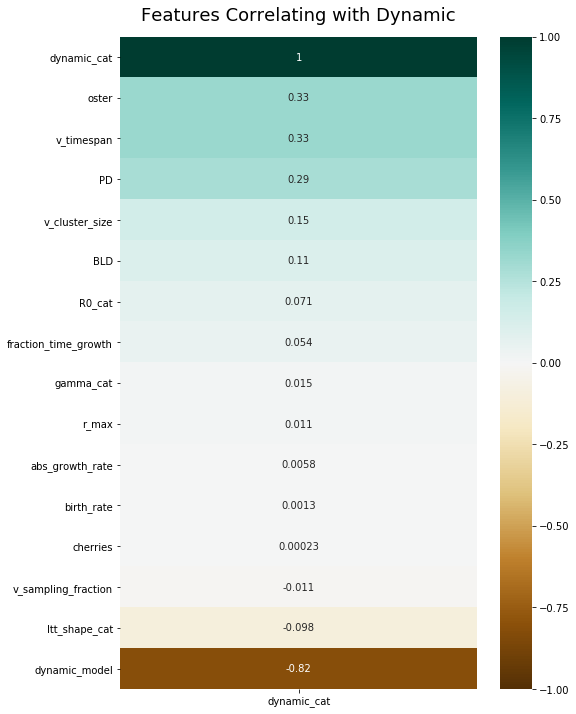

In [44]:
#check the features that are highly correlated to the output variable
plt.figure(figsize=(8, 12))
heatmap_outputvar = sns.heatmap(aly_df.corr()[['dynamic_cat']].sort_values(by='dynamic_cat', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap_outputvar.set_title('Features Correlating with Dynamic', fontdict={'fontsize':18}, pad=16);

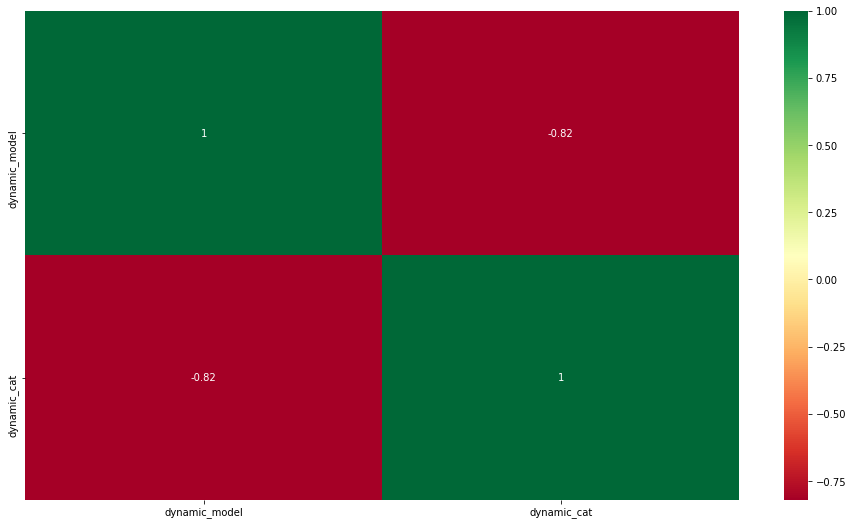

In [45]:
# most correlated features

corrmat = aly_df.corr()
top_corr_features = corrmat.index[abs(corrmat['dynamic_cat'])>0.45]
plt.figure(figsize=(16,9))
g = sns.heatmap(aly_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

#### 1-2-2 Spearman correlation

In [46]:
# Compute pairwise correlation of columns (Spearman rank correlation, non-linear)
aly_df.corr("spearman")

,v_sampling_fraction,v_cluster_size,v_timespan,oster,birth_rate,PD,abs_growth_rate,fraction_time_growth,r_max,cherries,BLD,dynamic_model,ltt_shape_cat,R0_cat,gamma_cat,dynamic_cat
v_sampling_fraction,1.000000,-0.483500,-0.217941,-0.223017,0.336920,-0.252397,-0.190027,0.036848,-0.213283,-0.081552,-0.224997,0.009122,0.046619,0.021746,0.005658,-0.010319
v_cluster_size,-0.483500,1.000000,0.656402,0.657219,-0.535075,0.711088,0.358656,0.096348,0.589242,0.018229,0.321577,-0.221039,-0.198051,0.093002,0.055322,0.235250
v_timespan,-0.217941,0.656402,1.000000,0.999678,-0.771359,0.933460,0.394450,0.168740,0.817741,-0.011974,0.372970,-0.344394,-0.247714,0.128956,0.083956,0.360034
oster,-0.223017,0.657219,0.999678,1.000000,-0.784429,0.933886,0.406576,0.163134,0.820557,-0.010161,0.382769,-0.343522,-0.248740,0.123035,0.084196,0.359241
birth_rate,0.336920,-0.535075,-0.771359,-0.784429,1.000000,-0.720685,-0.609391,0.022722,-0.726439,-0.055563,-0.514695,0.235699,0.179257,0.069795,-0.061512,-0.250209
PD,-0.252397,0.711088,0.933460,0.933886,-0.720685,1.000000,0.465565,0.182469,0.826460,0.011516,0.463997,-0.325529,-0.318205,0.155646,0.081833,0.340957
abs_growth_rate,-0.190027,0.358656,0.394450,0.406576,-0.609391,0.465565,1.000000,-0.188828,0.628165,0.036160,0.375987,-0.105733,-0.115085,-0.263518,0.050907,0.111503
fraction_time_growth,0.036848,0.096348,0.168740,0.163134,0.022722,0.182469,-0.188828,1.000000,0.195491,-0.016956,-0.008682,-0.065040,-0.092892,0.301028,0.009496,0.069873
r_max,-0.213283,0.589242,0.817741,0.820557,-0.726439,0.826460,0.628165,0.195491,1.000000,0.017353,0.371953,-0.252867,-0.233662,0.052092,0.086092,0.267263
cherries,-0.081552,0.018229,-0.011974,-0.010161,-0.055563,0.011516,0.036160,-0.016956,0.017353,1.000000,0.054368,0.021913,-0.010789,-0.026464,-0.016713,-0.015184


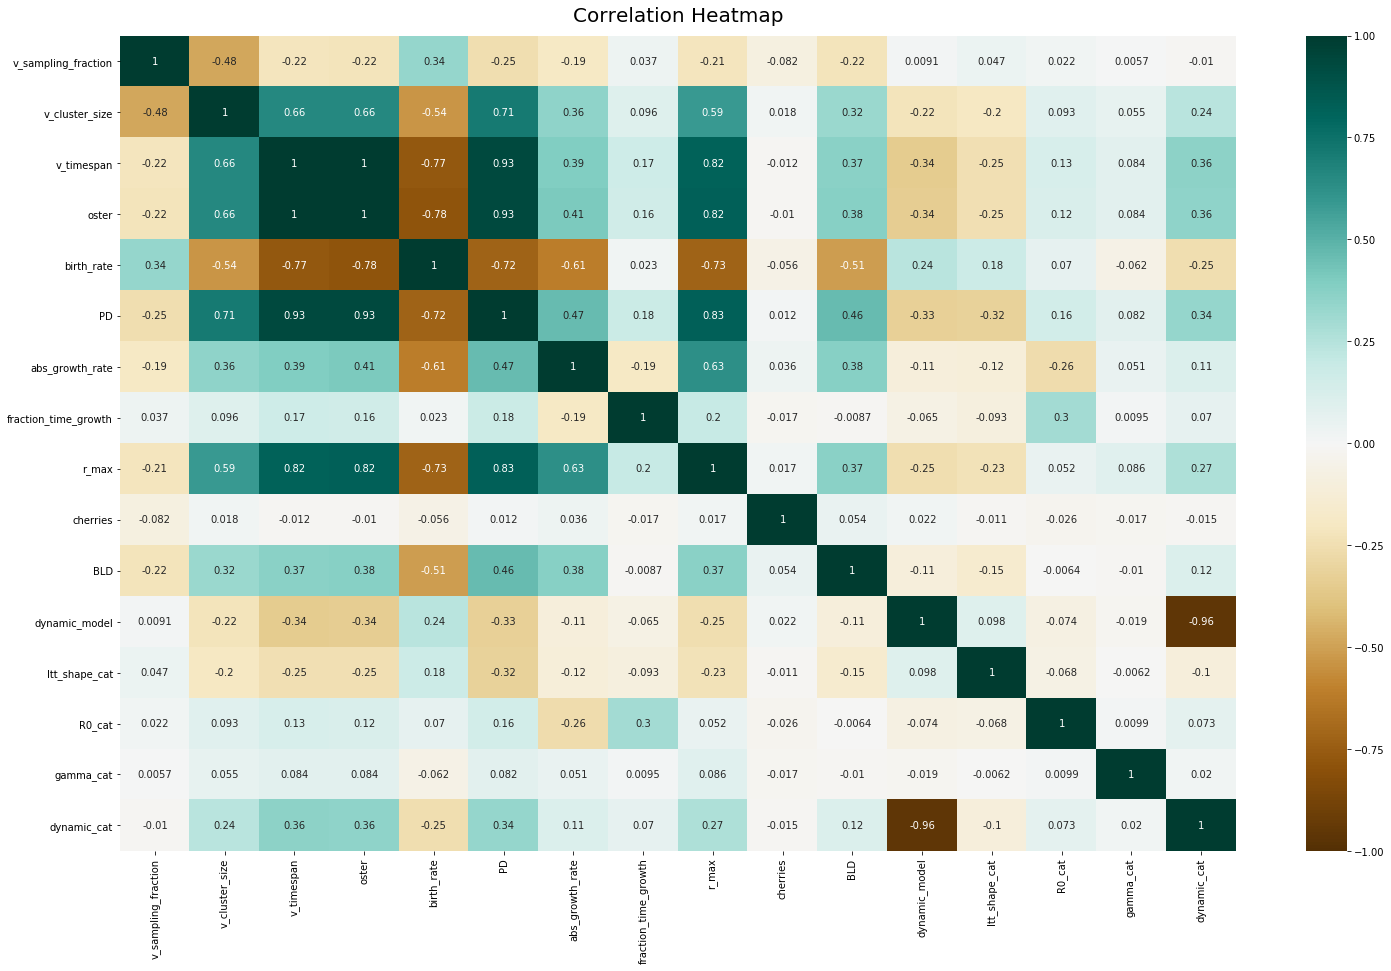

In [47]:
# Correlation Matrix

# Increase the size of the heatmap.
plt.figure(figsize=(25, 15))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(aly_df.corr('spearman'), vmin=-1, vmax=1, annot=True,cmap='BrBG')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=14);

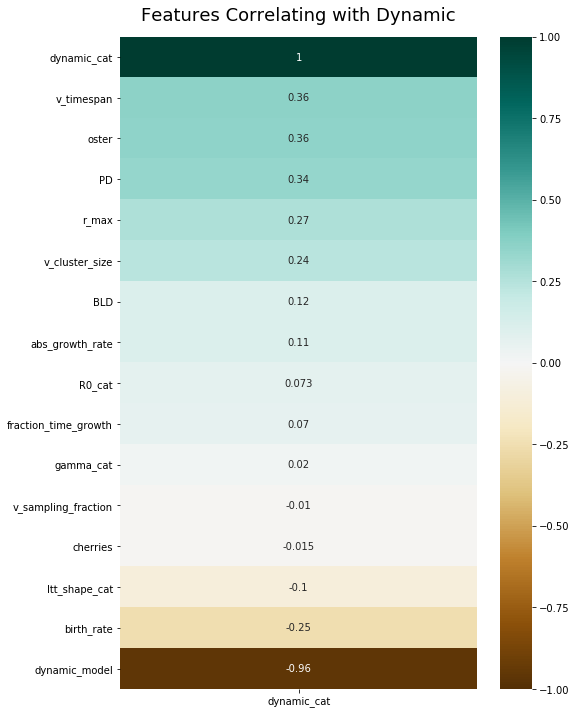

In [48]:
#check the features that are highly correlated to the output variable with Spearman
plt.figure(figsize=(8, 12))
heatmap_outputvar = sns.heatmap(aly_df.corr('spearman')[['dynamic_cat']].sort_values(by='dynamic_cat', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap_outputvar.set_title('Features Correlating with Dynamic', fontdict={'fontsize':18}, pad=16);

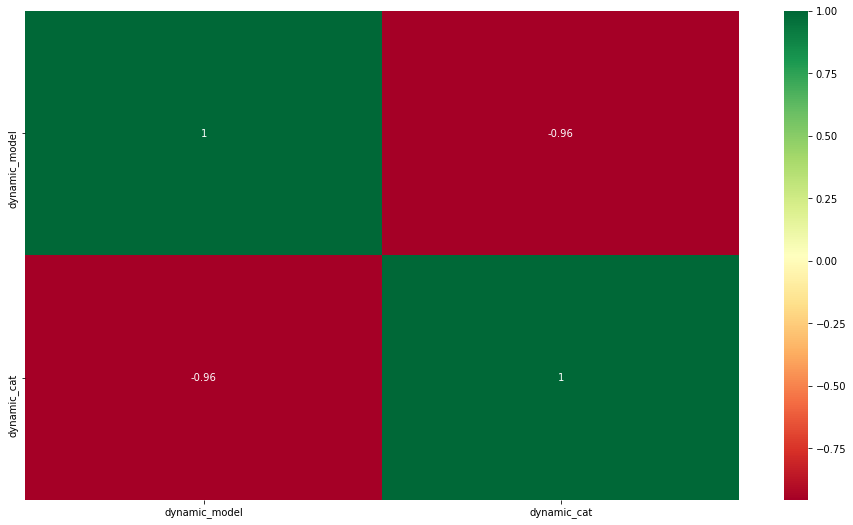

In [49]:
# most correlated features on spearman

corrmat = aly_df.corr('spearman')
top_corr_features = corrmat.index[abs(corrmat['dynamic_cat'])>0.5]
plt.figure(figsize=(16,9))
g = sns.heatmap(aly_df[top_corr_features].corr('spearman'),annot=True,cmap="RdYlGn")

#### From the above correlation plots it is evident that the features that really matter the most are:

* dynamic_model
* v_timespan
* oster
* PD
* r_max
* v_cluster_size
* birth rate

#### oster and v_timespan have a perfect positive correlation (with correlation coefficient value = 1.0)?

#### Spearm Correlation between num_feat_cols and label

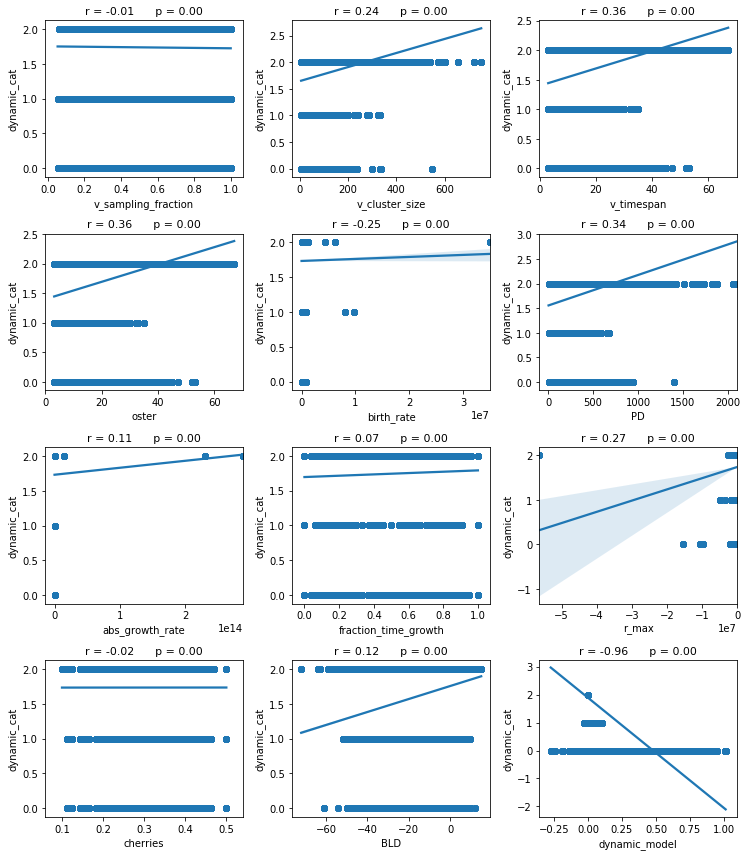

In [50]:
nr_rows = 4
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_plot_num_feats = [c for c in list(num_feat_cols) ]

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(x=aly_df[li_plot_num_feats[i]], y=aly_df['dynamic_cat'], ax = axs[r][c])
            # stp = stats.pearsonr(aly_df[num_feat_cols[i]], input_df['dynamic_cat'])
            stp = stats.spearmanr(aly_df[num_feat_cols[i]], aly_df['dynamic_cat'])
          
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()   

## Processing for Modeling

### Processing-1. One-hot encoding for the categorical feature
* ltt_shape_cat
* R0_cat
* gamma_cat

In [51]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

cat_feat_cols = list(set(cat_feat_cols)) # ['ltt_shape_cat', 'R0_cat', 'gamma_cat']
print(cat_feat_cols)
cat_onehot_feat = []
org_idx = node_df.index

for cat_feat in cat_feat_cols:
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    x = enc.fit_transform(node_df[cat_feat].values.reshape(-1, 1))
    n_dims = x.shape[-1]
    columns = [f'{cat_feat}_{i}' for i in range(n_dims)]
    cat_onehot_feat += columns
    cat_df = pd.DataFrame(x, index=org_idx, columns=columns)
    node_df = pd.concat([node_df, cat_df], axis=1)

['R0_cat', 'ltt_shape_cat', 'gamma_cat']


In [52]:
node_df

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,R0_bin,R0_cat,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,R0_cat_0,R0_cat_1,R0_cat_2,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3
1004,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.008410,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,1017.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1005,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.008410,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,1018.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1006,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.008410,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,1016.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1007,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.008410,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,31.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1008,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.008410,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,401.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3990577,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.357890,0.333333,44.336628,convex,0.400000,-10.5,541.0,"(-inf, 0.0]",0,"(-14.444, inf]",1,2,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3990578,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.357890,0.333333,44.336628,convex,0.400000,-10.5,941.0,"(-inf, 0.0]",0,"(-14.444, inf]",1,2,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3990579,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.357890,0.333333,44.336628,convex,0.400000,-10.5,939.0,"(-inf, 0.0]",0,"(-14.444, inf]",1,2,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3990580,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.357890,0.333333,44.336628,convex,0.400000,-10.5,329.0,"(-inf, 0.0]",0,"(-14.444, inf]",1,2,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Split the train/test sets (should put before imputing the missing values and calculating the correlation)

In [53]:
random_seed = 123
np.random.seed(random_seed)
split_dir = f'../data/{ds_name}/split_rs{random_seed}'
os.makedirs(split_dir, exist_ok=True)

from sklearn.model_selection import  train_test_split
#split the data for training and testing
train_ids, test_ids = train_test_split(tree_ids, test_size=0.2)
print(f"Train: {len(train_ids)}, Test: {len(test_ids)}")
print(test_ids[:10])

Train: 1852, Test: 463
[3334 3590 3176  515 2678 3892 3626  978  477  339]


In [55]:
train_background_df = background_df[background_df['sim'].isin(train_ids)]
test_background_df = background_df[background_df['sim'].isin(test_ids)]
train_node_df = node_df[node_df['sim'].isin(train_ids)]
test_node_df = node_df[node_df['sim'].isin(test_ids)]

print(f'Train: {train_background_df.shape[0] + train_node_df.shape[0]}')
print(f'Test: {test_background_df.shape[0] + test_node_df.shape[0]}')
train_node_df.head()

Train: 3155883
Test: 795674


,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,R0_bin,R0_cat,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,R0_cat_0,R0_cat_1,R0_cat_2,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3
1004,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,1017.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1005,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,1018.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1006,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,1016.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1007,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,31.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1008,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,401.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Processing-2. Normalize the input features:
* Use Standardization
* Use MinMax normalization to normalize data to [0, 1]

### Q7: Does normalization consider the background nodes?
A7: 

In [ ]:
train_node_df[num_feat_cols].hist(bins=50,figsize=(20,15))

In [57]:
# Standardization non-category features
std_scaler = preprocessing.StandardScaler().fit(train_node_df[num_feat_cols])
norm_num_feat_cols = [f'{col_name}-norm' for col_name in num_feat_cols]
norm_train_vals = std_scaler.transform(train_node_df[num_feat_cols])
norm_train_node_df = pd.DataFrame(norm_train_vals, columns=norm_num_feat_cols, index=train_node_df.index)
train_node_df = pd.concat([train_node_df, norm_train_node_df], axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A2EC0A3488>,
      dtype=object)

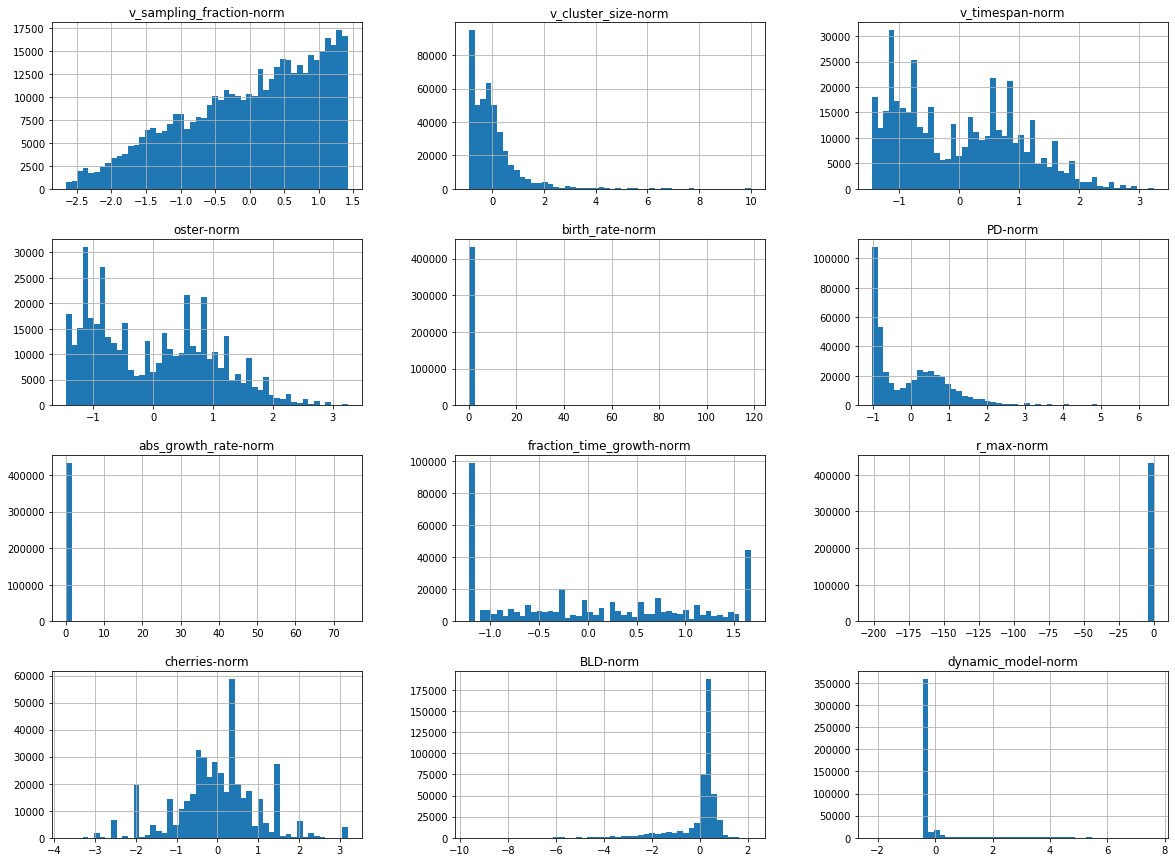

In [59]:
train_node_df[norm_num_feat_cols].hist(bins=50,figsize=(20,15))

In [60]:
print(std_scaler.mean_, std_scaler.scale_)

[ 6.71205170e-01  6.71157277e+01  2.28547285e+01  2.28827491e+01
  4.06539158e+03  2.89364899e+02  5.79026064e+10  4.21845144e-01
 -5.98680808e+03  3.15053621e-01 -2.35952277e+00  3.91231601e-02] [2.31419436e-01 6.85068929e+01 1.35940949e+01 1.35736789e+01
 2.95348049e+05 2.76348465e+02 3.90925499e+12 3.46315752e-01
 2.80303501e+05 5.79074968e-02 7.23689967e+00 1.27907838e-01]


In [61]:
norm_test_vals = std_scaler.transform(test_node_df[num_feat_cols])
norm_test_node_df = pd.DataFrame(norm_test_vals, columns=norm_num_feat_cols, index=test_node_df.index)
test_node_df = pd.concat([test_node_df, norm_test_node_df], axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A2EBE14A88>,
      dtype=object)

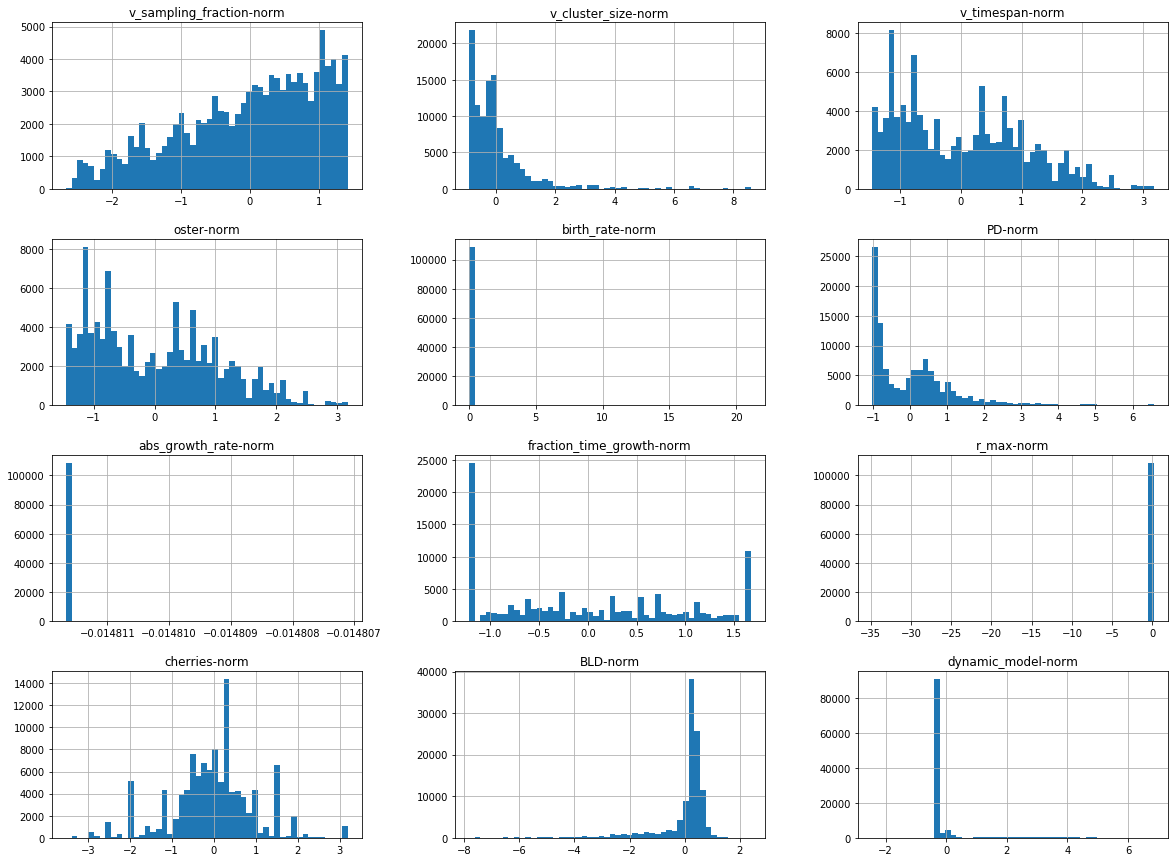

In [62]:
test_node_df[norm_num_feat_cols].hist(bins=50,figsize=(20,15))

In [63]:
# Obtain the onehot features
import re
all_cols = node_df.columns.values

onehot_cols = []
for feat_name, pattern in zip(['ltt_shape_onehot', 'R0_onehot', 'gamma_onehot'], 
                              ['ltt_shape_cat_\d*', 'R0_cat_\d*', 'gamma_cat_\d']):
    for feat_col in all_cols:
        m = re.match(pattern, feat_col)
        if m:
            feat_dict.setdefault(feat_name, []).append(m.group(0))
            
print(feat_dict)

{'ltt_shape': {0: 'concave', 1: 'concave_convex', 2: 'convex', 3: 'convex_concave'}, 'r0': {0: "(-inf, 0.0, 'right')", 1: "(0.0, 1.0, 'right')", 2: "(1.0, inf, 'right')"}, 'gamma': {0: "(-16.236, -14.444, 'right')", 1: "(-14.444, inf, 'right')", 2: "(-6179.216, -17.195, 'right')", 3: "(-17.195, -16.236, 'right')"}, 'dynamic': {0: 'decay', 1: 'growth', 2: 'static'}, 'ltt_shape_onehot': ['ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3'], 'R0_onehot': ['R0_cat_0', 'R0_cat_1', 'R0_cat_2'], 'gamma_onehot': ['gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3']}


In [64]:
print(train_node_df.shape)

(433120, 49)


In [65]:
train_node_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,R0_bin,R0_cat,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,R0_cat_0,R0_cat_1,R0_cat_2,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,dynamic_model-norm
1004,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,1017.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-2.587238,9.997305,1.702597,1.703714,-0.013765,6.400018,-0.014812,1.144437,0.022385,-0.198285,0.740583,-0.30587
1005,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,1018.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-2.587238,9.997305,1.702597,1.703714,-0.013765,6.400018,-0.014812,1.144437,0.022385,-0.198285,0.740583,-0.30587
1006,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,1016.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-2.587238,9.997305,1.702597,1.703714,-0.013765,6.400018,-0.014812,1.144437,0.022385,-0.198285,0.740583,-0.30587
1007,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,31.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-2.587238,9.997305,1.702597,1.703714,-0.013765,6.400018,-0.014812,1.144437,0.022385,-0.198285,0.740583,-0.30587
1008,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,401.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-2.587238,9.997305,1.702597,1.703714,-0.013765,6.400018,-0.014812,1.144437,0.022385,-0.198285,0.740583,-0.30587


In [66]:
train_node_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,R0_bin,R0_cat,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,R0_cat_0,R0_cat_1,R0_cat_2,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,dynamic_model-norm
1004,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,1017.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-2.587238,9.997305,1.702597,1.703714,-0.013765,6.400018,-0.014812,1.144437,0.022385,-0.198285,0.740583,-0.30587
1005,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,1018.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-2.587238,9.997305,1.702597,1.703714,-0.013765,6.400018,-0.014812,1.144437,0.022385,-0.198285,0.740583,-0.30587
1006,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,1016.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-2.587238,9.997305,1.702597,1.703714,-0.013765,6.400018,-0.014812,1.144437,0.022385,-0.198285,0.740583,-0.30587
1007,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,31.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-2.587238,9.997305,1.702597,1.703714,-0.013765,6.400018,-0.014812,1.144437,0.022385,-0.198285,0.740583,-0.30587
1008,c1,1003,A,static,0.0,0.072468,752,46.0,-7.193801,46.00841,0.046472,2058.0,3.599752,17.779701,0.818182,287.659273,concave,0.303571,3.0,401.0,"(1.0, inf]",2,"(-14.444, inf]",1,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-2.587238,9.997305,1.702597,1.703714,-0.013765,6.400018,-0.014812,1.144437,0.022385,-0.198285,0.740583,-0.30587


### Merge the background and non-background nodes

In [67]:
# train_full_df = train_node_df.merge(train_background_df, how='inner', left_on=list(train_background_df.columns), right_on=list(train_background_df.columns), left_index=True, right_index=True)
#train_full_df = train_node_df
#print(f'Train: {train_full_df.shape}')

#test_full_df = test_node_df
#print(f'Test: {test_full_df.shape}')

train_full_df = pd.concat([train_node_df, train_background_df])
print(f'Train: {train_full_df.shape}')

test_full_df = pd.concat([test_node_df, test_background_df])
print(f'Test: {test_full_df.shape}')

Train: (3155883, 49)
Test: (795674, 49)


In [68]:
# Save the train/test to the disk
train_full_df.to_csv(f'{split_dir}/train.csv', index=False)
test_full_df.to_csv(f'{split_dir}/test.csv', index=False)

In [69]:
train_full_df.head()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,R0_bin,R0_cat,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,R0_cat_0,R0_cat_1,R0_cat_2,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,dynamic_model-norm
7,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,7.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0,3,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.408658,0.080233,0.024046,0.02394,-0.005099,-0.236402,-0.005487,-1.019276,0.001174,-0.122821,0.243255,-0.109
8,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,132.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0,3,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.408658,0.080233,0.024046,0.02394,-0.005099,-0.236402,-0.005487,-1.019276,0.001174,-0.122821,0.243255,-0.109
9,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,513.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0,3,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.408658,0.080233,0.024046,0.02394,-0.005099,-0.236402,-0.005487,-1.019276,0.001174,-0.122821,0.243255,-0.109
10,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,230.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0,3,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.408658,0.080233,0.024046,0.02394,-0.005099,-0.236402,-0.005487,-1.019276,0.001174,-0.122821,0.243255,-0.109
11,Background,1003,Background,static,0.0,0.051202,573,84.0,-14.52041,84.003945,0.037381,12289.0,-1.998694,109.97519,0.170732,2915.519628,convex_concave,0.324376,5.0,255.0,"(-inf, 0.0]",0,"(-16.236, -14.444]",0,3,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.408658,0.080233,0.024046,0.02394,-0.005099,-0.236402,-0.005487,-1.019276,0.001174,-0.122821,0.243255,-0.109


In [70]:
train_full_df.tail()

,cluster_id,sim,state,dynamic,dynamic_model,v_sampling_fraction,v_cluster_size,v_timespan,gamma,oster,birth_rate,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,node,R0_bin,R0_cat,gamma_bin,gamma_cat,ltt_shape_cat,dynamic_cat,R0_cat_0,R0_cat_1,R0_cat_2,gamma_cat_0,gamma_cat_1,gamma_cat_2,gamma_cat_3,ltt_shape_cat_0,ltt_shape_cat_1,ltt_shape_cat_2,ltt_shape_cat_3,v_sampling_fraction-norm,v_cluster_size-norm,v_timespan-norm,oster-norm,birth_rate-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,dynamic_model-norm
3990577,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,541.0,"(-inf, 0.0]",0,"(-14.444, inf]",1,2,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.349653,-2.600439,-2.905665,-2.904815,-0.005098,-2.451029,-0.005487,-0.489028,-0.026458,3.112061,-3.75343,-0.109
3990578,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,941.0,"(-inf, 0.0]",0,"(-14.444, inf]",1,2,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.349653,-2.600439,-2.905665,-2.904815,-0.005098,-2.451029,-0.005487,-0.489028,-0.026458,3.112061,-3.75343,-0.109
3990579,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,939.0,"(-inf, 0.0]",0,"(-14.444, inf]",1,2,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.349653,-2.600439,-2.905665,-2.904815,-0.005098,-2.451029,-0.005487,-0.489028,-0.026458,3.112061,-3.75343,-0.109
3990580,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,329.0,"(-inf, 0.0]",0,"(-14.444, inf]",1,2,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.349653,-2.600439,-2.905665,-2.904815,-0.005098,-2.451029,-0.005487,-0.489028,-0.026458,3.112061,-3.75343,-0.109
3990581,c6,99,C,static,0.0,0.677846,8,7.0,0.130435,7.056338,0.181756,23.0,-50.076814,15.35789,0.333333,44.336628,convex,0.4,-10.5,542.0,"(-inf, 0.0]",0,"(-14.444, inf]",1,2,2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.349653,-2.600439,-2.905665,-2.904815,-0.005098,-2.451029,-0.005487,-0.489028,-0.026458,3.112061,-3.75343,-0.109


### Finalize the feature information and save to the file

In [71]:
all_cols = test_full_df.columns
print(all_cols)

Index(['cluster_id', 'sim', 'state', 'dynamic', 'dynamic_model',
       'v_sampling_fraction', 'v_cluster_size', 'v_timespan', 'gamma', 'oster',
       'birth_rate', 'PD', 'R0', 'abs_growth_rate', 'fraction_time_growth',
       'r_max', 'ltt_shape', 'cherries', 'BLD', 'node', 'R0_bin', 'R0_cat',
       'gamma_bin', 'gamma_cat', 'ltt_shape_cat', 'dynamic_cat', 'R0_cat_0',
       'R0_cat_1', 'R0_cat_2', 'gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2',
       'gamma_cat_3', 'ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2',
       'ltt_shape_cat_3', 'v_sampling_fraction-norm', 'v_cluster_size-norm',
       'v_timespan-norm', 'oster-norm', 'birth_rate-norm', 'PD-norm',
       'abs_growth_rate-norm', 'fraction_time_growth-norm', 'r_max-norm',
       'cherries-norm', 'BLD-norm', 'dynamic_model-norm'],
      dtype='object')


In [72]:
onehot_cols = feat_dict['ltt_shape_onehot'] + feat_dict['R0_onehot'] + feat_dict['gamma_onehot']

raw_cols = num_feat_cols + cat_feat_cols
norm_onehot_cols = norm_num_feat_cols + onehot_cols
print(f'Raw cols: {raw_cols}', len(raw_cols))
print(f'Norm with onehot cols: {norm_onehot_cols}', len(norm_onehot_cols))

feat_dict['raw_feats'] = raw_cols
feat_dict['norm_onehot_feats'] = norm_onehot_cols

Raw cols: ['v_sampling_fraction', 'v_cluster_size', 'v_timespan', 'oster', 'birth_rate', 'PD', 'abs_growth_rate', 'fraction_time_growth', 'r_max', 'cherries', 'BLD', 'dynamic_model', 'R0_cat', 'gamma_cat', 'ltt_shape_cat'] 15
Norm with onehot cols: ['v_sampling_fraction-norm', 'v_cluster_size-norm', 'v_timespan-norm', 'oster-norm', 'birth_rate-norm', 'PD-norm', 'abs_growth_rate-norm', 'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm', 'BLD-norm', 'dynamic_model-norm', 'ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3', 'R0_cat_0', 'R0_cat_1', 'R0_cat_2', 'gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3'] 23


In [73]:
import json 

with open('feat_dict0427.json', 'w') as outfile:
    json.dump(feat_dict, outfile, sort_keys=True, indent=4)